# import + functions

In [ ]:
# ignore_list = ['269_1_5','269_1_6','270_1_1','178_2_3']
ignore_list = ['269_1_5','269_1_6']


dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

## set up empty vars 
mirs = []

expert = []
hlesion = []
learning = []


# 1
reactivations_per_min = []
# 2
event_rate_binned = []
er_bins_relative_to_so = []
# 3
event_lens = []
# 4
av_coactive_len_per_chunk = []

e_coactive_freqs_counts = {}
hl_coactive_freqs_counts = {}
l_coactive_freqs_counts = {}

all_total_events = []
rel_task_nontask = []
chunks_task_nontask = []

task_nontask_num_spikes = []
task_nontask_e_len = []

chunk_expert = []
chunk_mid_time_post_onset = []
#5 
mouse_summed_amounts = []
ordered_sum = []
ordered_misordered_total = []


# warps = []


# loop across all mouse files
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        # current mouse
        mouse = '_'.join(pp_file.split('_')[0:3])
        
        if not mouse in ignore_list:

            # if session in one of the groups (and define which)   
            if mouse in list(expert_mice) + list(hlesion_mice) + list(learning_mice):
                if mouse in expert_mice:
                    expert += [1]
                    hlesion += [0]
                    learning += [0]               
                elif mouse in hlesion_mice:                
                    expert += [0]
                    hlesion += [1]
                    learning += [0]
                elif mouse in learning_mice:                
                    expert += [0]
                    hlesion += [0]
                    learning += [1]

                print(run_index)

                print(mouse)



                # load in sleep start time 
                current_sleep_start = sleep_start[mouse]
                params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_spans = params['time_span']

                # set path to processed files 
                current_mouse_path = dat_path + pp_file + '\\analysis_output'
                mirs += [mouse]

                ## set chunk vars 
                #1
                chunk_rpm = []
    #             chunk_warps = []
                #2
                chunk_binned_rate = []
                chunk_bins_relative_so = []
                #3
                chunk_event_lens = []

                #4
                coactive_freqs_chunk  = {}
                chunk_total_nontask_task_related_events = []
                total_events = 0
                chunk_task_num_spikes = []
                chunk_nontask_num_spikes = []
                chunk_task_e_len = []
                chunk_nontask_e_len = []

                #5
                chunk_summed_amounts = []
                chunk_ordered_sum = 0
                chunk_coactive_total = 0
                
                
                task_related = 0
                non_task_related = 0

                ## lopp across all chunk files
                for file in os.listdir(current_mouse_path):
                    if 'chunk' in file:
                        print(file)
                        current_data_path = current_mouse_path + '\\' + file + '\\'
                        chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                        data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')

                        ## filter this data
                        if sequential_filter == True: 
                            sequential_condition = data.ordering_classification == 'sequential'
                        else:
                            sequential_condition = np.array([True]*len(data.ordering_classification))

                        if sleep_filters_on == True:
                            if nrem_filter == True: 
                                nrem_condition = nrem__condition = data.nrem_events == 1
                            else:
                                nrem_condition = np.array([False]*len(data.nrem_events))

                            if rem_filter == True: 
                                rem_condition = rem__condition = data.rem_events == 1
                            else:
                                rem_condition = np.array([False]*len(data.rem_events))

                            if background_only == True:
                                rem_condition = rem__condition = data.rem_events == 0
                                nrem_condition = nrem__condition = data.nrem_events == 1

                        else:
                            nrem_condition = np.array([True]*len(data))
                            rem_condition = np.array([True]*len(data))




                        # filter is set up so that any true will carry forward 
                        filter_mask = sequential_condition * (nrem_condition + rem_condition)

                        filtered_chunk_data = data[filter_mask].reset_index()


                        # save out data
                        reactivations_found = len(filtered_chunk_data)



                        # this one depends on rem/nrem filter... 

    #                         # if sleep_filters_on is false, use all chunk time
                        if sleep_filters_on == False:
                            mins = np.diff(chunk_time)[0]
                        else:
                            # load in state times
                            rem_state_times = np.load(current_data_path + 'rem_state_times.npy')
                            nrem_state_times = np.load(current_data_path + 'nrem_state_times.npy')
                            if len(rem_state_times) > 0:
                                tot_rem = sum(np.diff(rem_state_times))[0]
                            else:
                                tot_rem = 0
                            if len(nrem_state_times) > 0:
                                tot_nrem = sum(np.diff(nrem_state_times))[0]
                            else:
                                tot_nrem = 0

                            # if background then use all non rem an dnon nrem times
                            if background_only:
                                mins = np.diff(chunk_time)[0] - (tot_rem+tot_nrem)
                            else:
                                # if both, use both 
                                if nrem_filter == True and rem_filter == True:
                                    mins = tot_rem+tot_nrem
                                elif nrem_filter == True and rem_filter == False:
                                    mins = tot_nrem
                                elif nrem_filter == False and rem_filter == True:
                                    mins = tot_rem
                        # convert to mins            
                        mins = mins/60

                        if mins > 0:
                            chunk_rpm += [reactivations_found/mins]

                        #2################################

#                             current_sleep_start = sleep_start[mouse] - 400
                            chunk_number = int(file.split('_')[0][-1])
                            start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]


                            # take away cumulative chunk offset - this gives time in terms of chunk
                            f_spike_times = filtered_chunk_data.first_spike_time.values - start_offset
                            # add on ephys time that chunk started - so its in ephys timestamps 
                            f_spike_times = f_spike_times + chunk_time[0]

                            # now make relative to sleep start time
                            f_spike_times_relative_to_so = f_spike_times - current_sleep_start 
                            # do the same but for rem and nrem start

                            # filter out anything that happened before sleep onset
                            f_spike_times_relative_to_so = f_spike_times_relative_to_so[f_spike_times_relative_to_so > 0]

                            ## calculate rate over time:
                            time_data = pd.Series(f_spike_times_relative_to_so)
                            if len(time_data) > 0:
#                                 # Calculate the number of bins required # 5 minute bins
#                                 num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
#                                 # Create bins and count the occurrences in each bin
#                                 chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
#                                 #remove extra final bin and convert to mins
#                                 chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60

                                # Calculate the number of bins required # 20s bins
                            #     num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
                                if time_data.max() - time_data.min() > 19:
                                    num_bins = int((time_data.max() - time_data.min())//20)
                                    # Create bins and count the occurrences in each bin
                                    chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
                                    #remove extra final bin and convert to mins
                                    chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60


                                    chunk_binned_rate += [list((chunk_event_rate*3).astype(float))] # *3 because its per 20s so we want it per minute )
                                    chunk_bins_relative_so += [list(chunk_relative_time_bins.astype(float))]

                        
                        #3########################################################

                        chunk_event_lens += list(filtered_chunk_data.event_length.values)

                        #4 ################################################# coactive stuff -300ms = coactive
                        event_proximity_filter =  0.3 #s (how close events have to be to each other to be clustered together as coacitve 

                        task_seqs = np.load(current_data_path + 'task_order_seqs.npy')+1
            
                        for motif_type in filtered_chunk_data.cluster_seq_type:
                            if motif_type in task_seqs:
                                task_related += 1
                            else:
                                non_task_related += 1
        
                        total_events += len(filtered_chunk_data.cluster_seq_type)

                        # normalise by number of each type: 
#                         if (6-len(task_seqs)) == 0:
#                             chunk_total_nontask_task_related_events += [[non_task_related,(task_related/len(task_seqs))]]
#                         else:
#                             chunk_total_nontask_task_related_events += [[non_task_related/(6-len(task_seqs)),(task_related/len(task_seqs))]]

                        chunk_mid_time_post_onset += [((sum(chunk_time)/2)-current_sleep_start)]

                        ### ignore the origonal clusterg rosp and remake them: 
                        start_times = filtered_chunk_data.first_spike_time.values
                        end_times = filtered_chunk_data.last_spike_time.values

                        clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

                        cluster_group = np.zeros(len(filtered_chunk_data))
                        for index,cluster in enumerate(clustered_events):
                            for item in cluster:
                                cluster_group[item] = int(index)
                        filtered_chunk_data['coactive_cluster_group'] = cluster_group

                        # work out how mnay coacitve in chunk: 
                        current_coactive_freqs_chunk = {}
                        for cluster in filtered_chunk_data.coactive_cluster_group.unique():
                            num = list(filtered_chunk_data.coactive_cluster_group.values).count(cluster)
                            if num in current_coactive_freqs_chunk:
                                current_coactive_freqs_chunk[num] += 1
                            else:
                                current_coactive_freqs_chunk[num] = 1

                        avs =[]
                        for item in current_coactive_freqs_chunk:
                            avs += current_coactive_freqs_chunk[item] * [item]
                        av_coactive_len_per_chunk += [np.mean(avs)]
                        if mouse in expert_mice:
                            chunk_expert += [1]
                        elif mouse in hlesion_mice:
                            chunk_expert += [2]
                        elif mouse in learning_mice:
                            chunk_expert += [3]


                        # make it relative:
                        current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)

                        coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
                        rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
                        for index,item in enumerate(rel_coactive_freqs):
                            num = int(coactive_freqs_keys[index])
                            if num in coactive_freqs_chunk:
                                coactive_freqs_chunk[num] += [item]
                            else:
                                coactive_freqs_chunk[num] = [item]


                        task_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type.isin(task_seqs)]
                        non_task_events = filtered_chunk_data[~filtered_chunk_data.cluster_seq_type.isin(task_seqs)]

                        chunk_task_num_spikes+=list(task_events.num_spikes)
                        chunk_nontask_num_spikes+=list(non_task_events.num_spikes)
                        chunk_task_e_len+=list(task_events.event_length)
                        chunk_nontask_e_len+=list(non_task_events.event_length)


                        # 5 ##############################################################################

                        ############################################## split into multi clusters and process

                        multi_cluster_df = pd.DataFrame({'cluster_seq_type':[],
                         'num_spikes':[],
                         'num_neurons':[],
                         'first_spike_time':[],
                         'event_length':[],
                         'last_spike_time':[],
                         'cluster_spike_times':[],
                         'cluster_neurons':[],
                         'spike_plotting_order':[],
                         'coactive_cluster_group':[],
                         'new_cluster_group':[],
                         'cluster_order_first_spike_defined':[],
                         'cluster_order_mean_weighted_spikes_defined':[],
                         'pairs_mean_ordering':[],
                         'catagories_mean_ordering':[],
                         'pairs_fs_ordering':[],
                         'catagories_fs_ordering':[],
                         'real_sequence_order':[]})
                        meaned_order = []
                        fs_order = []
                        event_times = []
                        multi_cluster_df
                        count = 0
                        for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
                            group_mask = filtered_chunk_data.coactive_cluster_group == group
                            current_cluster = filtered_chunk_data[group_mask]
                            if len(current_cluster) > 1:
                                means = []
                                event_types = []
                                fs_orders = []
                                for index,events in enumerate(current_cluster.cluster_spike_times):
                                    event_types += [current_cluster.cluster_seq_type.values[index]]
                                    # calculate event order based on spike time weighted mean
                                    means += [np.mean(ast.literal_eval(events))]
                                    # calculate order based on first spike time:
                                    fs_orders += [current_cluster.first_spike_time.values[index]]

                                # order by mean time:    
                                meaned_order += [list(np.array(event_types)[np.argsort(means)])]
                                # order by first spike:
                                fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

                                event_times += [fs_orders]

                                current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
                                current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
                                current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

                                if count == 0:
                                    multi_cluster_df = current_cluster.copy()
                                else:
                                    # Concatenate the DataFrames vertically (row-wise)
                                    multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                                    # Reset the index if needed
                                    multi_cluster_df = multi_cluster_df.reset_index(drop=True)

                                count += 1

                        ############################################## Load in seq order data 

                        awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

                        for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
                            if not M_I_R == 'not_suitable':
                                mir = '_'.join(M_I_R.split('_')[0:3])
                                if mir == mouse:
                                    c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 

                        sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

                        import ast
                        seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
                        num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)

                        ############################################## calculate catagory breakdown

                        if len(multi_cluster_df.coactive_cluster_group.unique()) > 1:

                            real_order = list(np.array(seq_order)+1)

                            # # mean ordering first : 
                            if len(real_order) > 3: # 3 will always be ordered so exclude
                                relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,meaned_order)
                                summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
                            #     labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
                            #     fig, ax = plt.subplots()
                            #     ax.bar(labels,summed_amounts)
                            #     ax.set_title('catagory occurances (seqs ordered by mean spike time)')

                            #     SaveFig('catagory occurances_1___chunk'+ str(index_+1) + '.png',chunk_path)

                                all_pair_outcomes_todf = []
                                all_pairs_todf = []
                                for group in multi_cluster_df.new_cluster_group.unique():
                                    group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                                    group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                                    all_pairs = []
                                    all_pair_outcomes = []
                                    for index,pair_ in enumerate(group_pairs[0:-1]):
                                        all_pairs += [pair_]
                                        all_pair_outcomes += [group_pair_outcomes[index]]

                                    all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
                                    all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

                                multi_cluster_df['pairs_mean_ordering'] = all_pairs_todf
                                multi_cluster_df['catagories_mean_ordering'] = all_pair_outcomes_todf

                                multi_cluster_df['real_sequence_order'] = [real_order]*len(multi_cluster_df)

                                chunk_summed_amounts += [list(np.array(summed_amounts)/sum(summed_amounts))]

                                chunk_ordered_sum += sum(summed_amounts[0:3])
                                chunk_coactive_total += sum(summed_amounts[0:4])
                            else:
                                print('only 3 seqs')

                            
                            
#                             print(chunk_summed_amounts)
                            
        
                # outside of chunk loop ################################################
                
                # changed how i do this, now task freq is worke dout by adding up instances across all chunks and lookig at the proportion rather than averageing across chunks 
                if (6-len(task_seqs)) == 0:
                    chunk_total_nontask_task_related_events += [[non_task_related,(task_related/len(task_seqs))]]
                else:
                    chunk_total_nontask_task_related_events += [[non_task_related/(6-len(task_seqs)),(task_related/len(task_seqs))]]      

                ### add to animal vars
                #1
                reactivations_per_min += [np.mean(chunk_rpm)]
                if np.mean(chunk_rpm) < 3:
                    print('!!!!!')
                #2
                event_rate_binned +=[chunk_binned_rate]
                er_bins_relative_to_so +=[chunk_bins_relative_so]
                #3
                event_lens += [chunk_event_lens]


                #4 #########    
                relative = []
                totals = [sum(item) for item in chunk_total_nontask_task_related_events]
                for i,item in enumerate(chunk_total_nontask_task_related_events):
                    relative += [list(np.array(item)/totals[i])]

                all_total_events += [total_events]

                num_task_order_seqs = len(np.load(current_data_path+ 'task_order_seqs.npy')+1)

                rel_task_nontask += [[np.mean(conactinate_nth_items(relative)[1]),np.mean(conactinate_nth_items(relative)[0])]]

                chunks_task_nontask += conactinate_nth_items(relative)[1]

                for item in coactive_freqs_chunk:
                    if mouse in expert_mice:
                        if item in e_coactive_freqs_counts:
                            e_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            e_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                    elif mouse in hlesion_mice:
                        if item in hl_coactive_freqs_counts:
                            hl_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            hl_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                    elif mouse in learning_mice:
                        if item in l_coactive_freqs_counts:
                            l_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            l_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]



                task_nontask_num_spikes+= [[np.mean(chunk_task_num_spikes),np.mean(chunk_nontask_num_spikes)]]
                task_nontask_e_len+= [[np.mean(chunk_task_e_len),np.mean(chunk_nontask_e_len)]]

                #5 #############

                if len(chunk_summed_amounts) > 0:
                    c_summed_amounts = []
                    for item in conactinate_nth_items(chunk_summed_amounts):
                        c_summed_amounts +=[np.mean(item)]
                    mouse_summed_amounts += [c_summed_amounts]
                else:
                    mouse_summed_amounts += [[]]
                    
                    
                ordered_sum += [chunk_ordered_sum]
                ordered_misordered_total += [chunk_coactive_total]

                            
                            

0
136_1_3
chunk1_8700to9300
chunk2_10000to11600
chunk3_11900to12500
1
136_1_4
chunk1_7600to8200
chunk2_8800to9400
chunk3_9950to10550
2
148_2_2
chunk1_3000to4000
chunk2_4000to5000
chunk3_5000to6000
3
149_1_1
chunk1_8300to9300
chunk2_9600to10600
chunk3_12600to13600
4
178_1_4
chunk1_7500to8100
chunk2_8500to9100
chunk3_9500to10100
5
178_1_5
chunk1_8000to8600
chunk2_9000to9600
chunk3_12200to12800
6
178_1_6
chunk1_8600to9300
chunk2_10000to10600
chunk3_12000to12600
7
178_1_7
chunk1_8300to10000
chunk2_10500to11200
chunk3_13300to14300
8
178_1_8
chunk1_11300to12000
chunk2_13200to13800
chunk3_16400to17000
9
178_1_9
chunk1_9000to9900
chunk2_10100to10700
chunk3_11300to11900
10
178_2_1
chunk1_8500to9200
only 3 seqs
chunk2_9900to10500
only 3 seqs
chunk3_14000to14600
only 3 seqs
11
178_2_2
chunk1_12300to12900
chunk2_13600to14200
chunk3_15400to16000
12
178_2_3
chunk1_9500to10500
chunk2_11800to12800
chunk3_13000to14000
!!!!!
13
178_2_4
chunk1_9700to10500
chunk2_11500to12100
chunk3_14000to14400
chunk4_15

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # load in the shuffled data - extract number of sequenes found
# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\synthetic_data\shuffled\ppseq_output\\"
# shuffle_events_per_min = []
# for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
#     file = os.listdir(PP_PATH)[iteration_]
#     data_path = os.path.join(PP_PATH,file)+ r'//_final_analysis_output//'
#     clust_events_per_min = 0
#     all_chunks_len = 0
#     current_mir = file.split('run')[0][:-1]
#     for file in os.listdir(data_path):
#         if 'chunk' in file:
#             current_data_path = os.path.join(data_path,file)+ r'//'
#             replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
#             if 'ordering_classification' in list(replay_clusts):
#                 interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
#                 # only sequential events
#                 clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
#                 # clust_events_per_min += len(replay_clusts)
#                 all_chunks_len += interval_length/60
#             else:
#                 print('no ordering classification...')
            
#     if all_chunks_len > 0:
#         shuffle_events_per_min += [clust_events_per_min/all_chunks_len]


# # load in the non shuffle - extract number of sequuences found 
# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\synthetic_data\non_shuffled\ppseq_output\\"
# non_shuff_events_per_min = []
# for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
#     file = os.listdir(PP_PATH)[iteration_]
#     data_path = os.path.join(PP_PATH,file)+ r'//_final_analysis_output//'
#     clust_events_per_min = 0
#     all_chunks_len = 0
#     current_mir = file.split('run')[0][:-1]
#     for file in os.listdir(data_path):
#         if 'chunk' in file:
#             current_data_path = os.path.join(data_path,file)+ r'//'
#             replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
#             if 'ordering_classification' in list(replay_clusts):
#                 interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
#                 # only sequential events
#                 # clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
#                 clust_events_per_min += len(replay_clusts)
#                 all_chunks_len += interval_length/60
#             else:
#                 print('no ordering classification...')

#     if all_chunks_len > 0:
#         non_shuff_events_per_min += [clust_events_per_min/all_chunks_len]
        
# outpath = r'Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\\'
# pd.DataFrame({'id':mirs,'c_shuffled_epm':shuffle_events_per_min,'non_shuffled_epm':non_shuff_events_per_min}).to_csv(outpath+ 'circular_shuffle_test.csv')


In [5]:
def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()

In [6]:
# load in the csv:
circular_shuffle_df = pd.read_csv(r'Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\circular_shuffle_test.csv')

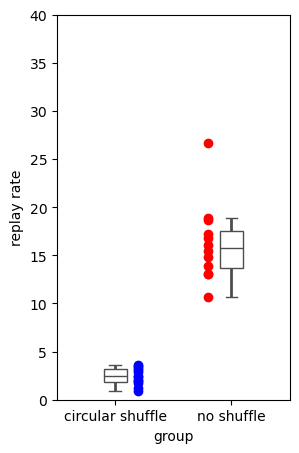

In [7]:
shuffle_events_per_min = circular_shuffle_df.c_shuffled_epm.values
non_shuff_events_per_min = circular_shuffle_df.non_shuffled_epm.values

fig, ax = plt.subplots(1, 1, figsize=(3, 5))

ax.plot([0.2]*len(shuffle_events_per_min),shuffle_events_per_min,'o', color = 'blue')
ax.plot([0.8]*len(non_shuff_events_per_min),non_shuff_events_per_min,'o', color = 'red')

ax.set_ylim(0,40)

# for i in range(len(shuffle_events_per_min)):
#     ax.plot([0.2,0.8],[shuffle_events_per_min[i],non_shuff_events_per_min[i]], 'o-')

plt_df = pd.DataFrame({'group': (['circular shuffle'] * len(shuffle_events_per_min)) + (['no shuffle'] * len(non_shuff_events_per_min)) , 'replay rate': list(shuffle_events_per_min)+list(non_shuff_events_per_min)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('circular_shuff.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


In [15]:
import scipy

print(scipy.stats.shapiro(shuffle_events_per_min))
print(scipy.stats.shapiro(non_shuff_events_per_min))

#paired t-test
print(scipy.stats.ttest_rel(shuffle_events_per_min, non_shuff_events_per_min))

diff =  non_shuff_events_per_min - shuffle_events_per_min
cohen_d = diff.mean() / diff.std(ddof=1)
print(cohen_d)

ShapiroResult(statistic=np.float64(0.9547968582522977), pvalue=np.float64(0.7077844361790105))
ShapiroResult(statistic=np.float64(0.8884986168405241), pvalue=np.float64(0.11270468066831035))
TtestResult(statistic=np.float64(-12.174829248104608), pvalue=np.float64(1.0024376812768496e-07), df=np.int64(11))
3.514570471865462
